# Detailed DRT recovery walkthrough
This tutorial demonstrates in detail the usage of the `Inverter` class to estimate the DRT from impedance data, using simulated data from a simple ZARC circuit as an example.

In [2]:
import numpy as np
import pandas as pd
import os
import sys
import time
import matplotlib.pyplot as plt
%matplotlib notebook
from copy import deepcopy
import glob

from bayes_drt.inversion import Inverter
from bayes_drt import eis_utils as gt

%load_ext autoreload
%autoreload 2

# 1. Load simulated data
For this example, we use impedance simulated from a circuit consisting of a ZARC element in series with an ohmic resistance. Random noise obeying J.R. Macdonald's proportional error model (https://doi.org/10.1016/0013-4686(90)80002-6) was added to the exact impedance.

In [3]:
# set plotting params
datadir = '../data'

tick_size = 9
label_size = 11

plt.rcParams['font.family'] = 'serif'
plt.rcParams["mathtext.fontset"] = "dejavuserif"
plt.rcParams['xtick.labelsize'] = tick_size
plt.rcParams['ytick.labelsize'] = tick_size
plt.rcParams['axes.labelsize'] = label_size
plt.rcParams['legend.fontsize'] = tick_size - 1

In [4]:
# load simulated data
circuit = 'ZARC'
err_model = 'Macdonald'
noise_level = 1.0
Zdf = pd.read_csv(os.path.join(datadir,'simulated',f'Z_{circuit}_{err_model}_{noise_level}.csv'))
# make complex impedance array
Zc = Zdf['Zreal'].values + 1j*Zdf['Zimag'].values
# get frequency vector for convenience
freq = Zdf['Freq'].values
# load true drt
g_true = pd.read_csv(os.path.join(datadir,'simulated',f'gamma_{circuit}.csv'))

<IPython.core.display.Javascript object>


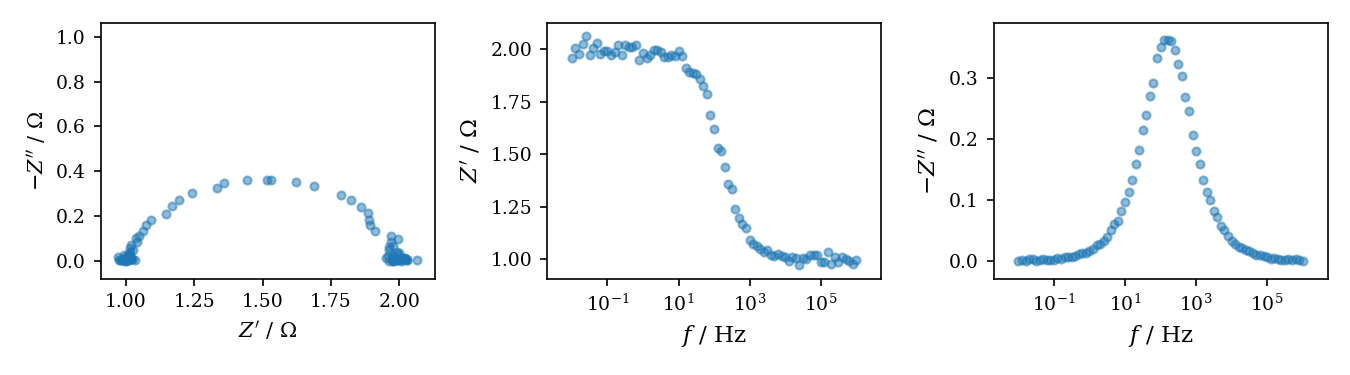

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


In [5]:
# plot the noisy impedance data
fig,axes = plt.subplots(1,3,figsize=(9,2.5))
gt.plot_full_eis(Zdf,axes=axes,bode_cols=['Zreal','Zimag'],s=15,alpha=0.5)
fig.tight_layout()

# 2. The `Inverter` class

The `Inverter` class is the core of the functionality in `bayes_drt`. It provides access to the calibrated hierarchical Bayesian (CHB) model for EIS inversion, which can be fitted using Hamiltonian Monte Carlo (HMC) sampling or L-BFGS optimization for DRT and DDT recovery. It also stores fit parameters and provides methods to predict the impedance, the error structure of the data, and the underlying distributions. The sections below illustrate the application of the available DRT recovery methods to simulated data. 

## 2a. CHB fit via HMC sampling

First, we apply the CHB model and obtain an estimate of the posterior distribution using the HMC sampler in `Stan`. This approach is accessible via the `bayes_fit` method of the `Inverter` class. If you are running your code in a Jupyter notebook, you can monitor sampling progress in the Anaconda Prompt (or other terminal) window.

### Creating an `Inverter` instance
When we create an `Inverter` instance, we need to specify what kind of distribution(s) we want to fit to the data. This information is provided in the `distributions` argument when we initialize the object. The `distributions` argument is a nested dictionary: for each distribution, we provide a name with a dictionary containing the necessary parameters to define the distribution. For this example, we need to recover only the DRT, which is simple to specify.

In [6]:
# Create an Inverter instance for DRT recovery
inv_hmc = Inverter(distributions={'DRT':{'kernel':'DRT'}})
# view the distributions dict
inv_hmc.distributions

{'DRT': {'kernel': 'DRT', 'dist_type': 'series'}}

In the cell above, we indicate that there is one distribution named 'DRT', which uses a DRT-type kernel. For the DRT, this is the only information that must be provided; all other necessary information (i.e. the fact that it is a series distribution) can be inferred from the kernel. Note that we could have named the distribution anything we wanted; the distribution name does not have to match the kernel type. For more information about specifying distributions, see the DDT and multi-distribution tutorials.

By default, the Inverter class initializes with a DRT distribution if the `distributions` argument is not provided. Thus, the following code produces the same result:

In [7]:
# Create an Inverter instance with default settings
inv_hmc = Inverter()
# view the distributions dict
inv_hmc.distributions

{'DRT': {'kernel': 'DRT', 'dist_type': 'series'}}

### Sampling the posterior distribution
Now that the `Inverter` instance is created with the desired distribution, we can fit it to the data using the `bayes_fit` method. The fit method requires two arguments: the measurement frequencies (a real-valued array) and the measured impedance (a complex-valued array).

In [8]:
# Sample the posterior distribution
start = time.time()
inv_hmc.bayes_fit(freq,Zc)
elapsed = time.time() - start
print('HMC sampling time: {:.2f} s'.format(elapsed))

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


HMC sampling time: 62.64 s


`bayes_fit` is the slowest of the inversion algorithms included in `bayes_drt`, but is generally the most accurate and provides a credible interval in addition to a point estimate. Runtimes for `bayes_fit` can vary widely depending on the spectrum, the amount of noise in the data, and the state of your computer. The warning raised above ("Maximum (flat) parameter count exceeded...") simply indicates that diagnostic checks were skipped because there are over 1,000 parameters in the model. This will often be the case and is not, by itself, cause for concern.

*Note:* The `bayes_fit` method (and the other fit methods described below) automatically calculates all required matrices, including the $\mathbf{A}$ matrices, which require numerical evaluation of a number of integrals. By default, the `Inverter` class initializes the basis time constants ($\tau$ mesh) at a density of 10 ppd starting at $1/(2\pi f_1)$ and ending at $1/(2\pi f_N)$, where $f_1$ is the highest measured frequency and $f_N$ is the lowest measured frequency. As long as the impedance data is also logarithmically equispaced at 10 ppd, this results in the basis time constants being the inverse of the measurement frequencies, and the $\mathbf{A}$ matrices are therefore Toeplitz matrices, such that only the first row and/or column of each matrix needs to be calculated. The inverse length scale for the basis functions, $\epsilon$, is also set automatically if not specified. The default $\tau$ mesh should work well unless there are impedance features that are not fully captured in the measured frequency range; in this case, it is best to set an expanded $\tau$ mesh, as shown in the extrapolation tutorial. After fitting, the matrices are stored in `distribution_matrices`, while the $\tau$ mesh and $\epsilon$ value are stored in the `distributions` attribute.

In [9]:
# View matrices stored for DRT
inv_hmc.distribution_matrices['DRT'].keys()

dict_keys(['A_re', 'A_im', 'L0', 'L1', 'L2'])

In [10]:
# View tau mesh and epsilon
inv_hmc.distributions

{'DRT': {'kernel': 'DRT',
  'dist_type': 'series',
  'tau': array([1.00000000e-06, 1.25892541e-06, 1.58489319e-06, 1.99526231e-06,
         2.51188643e-06, 3.16227766e-06, 3.98107171e-06, 5.01187234e-06,
         6.30957344e-06, 7.94328235e-06, 1.00000000e-05, 1.25892541e-05,
         1.58489319e-05, 1.99526231e-05, 2.51188643e-05, 3.16227766e-05,
         3.98107171e-05, 5.01187234e-05, 6.30957344e-05, 7.94328235e-05,
         1.00000000e-04, 1.25892541e-04, 1.58489319e-04, 1.99526231e-04,
         2.51188643e-04, 3.16227766e-04, 3.98107171e-04, 5.01187234e-04,
         6.30957344e-04, 7.94328235e-04, 1.00000000e-03, 1.25892541e-03,
         1.58489319e-03, 1.99526231e-03, 2.51188643e-03, 3.16227766e-03,
         3.98107171e-03, 5.01187234e-03, 6.30957344e-03, 7.94328235e-03,
         1.00000000e-02, 1.25892541e-02, 1.58489319e-02, 1.99526231e-02,
         2.51188643e-02, 3.16227766e-02, 3.98107171e-02, 5.01187234e-02,
         6.30957344e-02, 7.94328235e-02, 1.00000000e-01, 1.2589254

The results of the fit can be accessed via the `Inverter` object. The `predict_distribution` method returns the recovered DRT, while the `predict_Z` method returns the fitted impedance, as shown in the plotting function defined below. When the solution is obtained via HMC sampling, as is the case for `bayes_fit`, the `predict_distribution` and `predict_Z` methods also take an optional `percentile` argument, which can be used to generate credible intervals (CIs). These methods are demonstrated below. 

### Evaluating the DRT
We start by evaluating and visualizing the recovered DRT using the `predict_distribution` method. The first argument of `predict_distribution` is the user-defined distribution name (in this case, 'DRT'); if no value is supplied, a dict of all fitted distributions will be returned, as shown below. We can also optionally specify a $\tau$ array over which to evaluate the distribution with the `eval_tau` parameter; otherwise, the $\tau$ mesh for the distribution will be used.

In [11]:
# call predict_distribution without specifying a distribution name
inv_hmc.predict_distribution()

{'DRT': array([ 8.51045951e-04,  1.54891610e-03,  2.11319995e-03,  2.65961754e-03,
         3.23724387e-03,  3.67170244e-03,  3.96347427e-03,  4.12501070e-03,
         4.24359249e-03,  4.38249215e-03,  4.52639669e-03,  4.79225606e-03,
         5.44952906e-03,  6.65699418e-03,  8.72851953e-03,  1.18904154e-02,
         1.62507354e-02,  2.13670710e-02,  2.73936723e-02,  3.39336885e-02,
         4.08836936e-02,  4.85911536e-02,  5.87844704e-02,  7.49937298e-02,
         1.01163999e-01,  1.42939865e-01,  2.08423835e-01,  2.91624113e-01,
         3.72105313e-01,  4.30577074e-01,  4.52958098e-01,  4.32189358e-01,
         3.76387105e-01,  2.97460722e-01,  2.17266320e-01,  1.52849835e-01,
         1.08080925e-01,  7.72186939e-02,  5.61487568e-02,  4.29985625e-02,
         3.40305783e-02,  2.79857156e-02,  2.35654310e-02,  1.96538378e-02,
         1.63816323e-02,  1.35869207e-02,  1.10703128e-02,  8.87229064e-03,
         7.22986089e-03,  5.95848487e-03,  5.02646161e-03,  4.39052222e-03,
     

In [12]:
# call predict_distribution with distribution name
inv_hmc.predict_distribution('DRT')

array([ 8.51045951e-04,  1.54891610e-03,  2.11319995e-03,  2.65961754e-03,
        3.23724387e-03,  3.67170244e-03,  3.96347427e-03,  4.12501070e-03,
        4.24359249e-03,  4.38249215e-03,  4.52639669e-03,  4.79225606e-03,
        5.44952906e-03,  6.65699418e-03,  8.72851953e-03,  1.18904154e-02,
        1.62507354e-02,  2.13670710e-02,  2.73936723e-02,  3.39336885e-02,
        4.08836936e-02,  4.85911536e-02,  5.87844704e-02,  7.49937298e-02,
        1.01163999e-01,  1.42939865e-01,  2.08423835e-01,  2.91624113e-01,
        3.72105313e-01,  4.30577074e-01,  4.52958098e-01,  4.32189358e-01,
        3.76387105e-01,  2.97460722e-01,  2.17266320e-01,  1.52849835e-01,
        1.08080925e-01,  7.72186939e-02,  5.61487568e-02,  4.29985625e-02,
        3.40305783e-02,  2.79857156e-02,  2.35654310e-02,  1.96538378e-02,
        1.63816323e-02,  1.35869207e-02,  1.10703128e-02,  8.87229064e-03,
        7.22986089e-03,  5.95848487e-03,  5.02646161e-03,  4.39052222e-03,
        3.89298962e-03,  

<IPython.core.display.Javascript object>


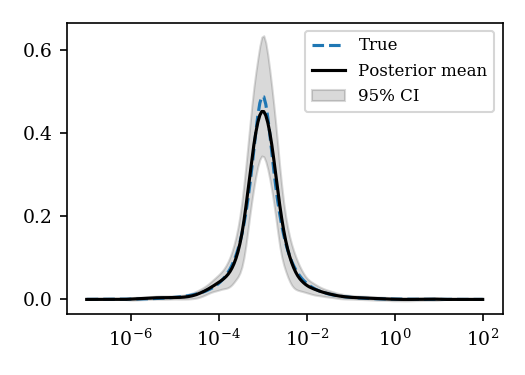

In [13]:
"Use predict_distribution to evaluate the recovered DRT and its CI"
# define a finely spaced tau vector for plotting
tau_plot = np.logspace(-7,2,200)
# Evaluate the DRT at each tau in tau_plot. For the bayes_fit method, this returns the posterior mean
g_pred = inv_hmc.predict_distribution('DRT',eval_tau=tau_plot)
# get the low and high limits of the DRT CI
g_lo = inv_hmc.predict_distribution('DRT',eval_tau=tau_plot,percentile=2.5)
g_hi = inv_hmc.predict_distribution('DRT',eval_tau=tau_plot,percentile=97.5)

fig,ax = plt.subplots(figsize=(3.5,2.5))
# plot the true DRT
ax.plot(g_true['tau'],g_true['gamma'],ls='--',label='True')
# plot the recovered DRT
ax.plot(tau_plot,g_pred,label='Posterior mean',c='k')
# plot the recovered CI
ax.fill_between(tau_plot,g_lo,g_hi,label='95% CI',color='k',alpha=0.15)

ax.set_xscale('log')
ax.legend()

fig.tight_layout()

The recovered DRT matches the true DRT very closely: the peak of the posterior mean is just slightly depressed relative to the true peak in the DRT, and the 95% CI captures the true DRT. 

### Predicting the impedance
Next, we plot the fit of the impedance data, using `predict_Z` to calculate the model impedance.

<IPython.core.display.Javascript object>


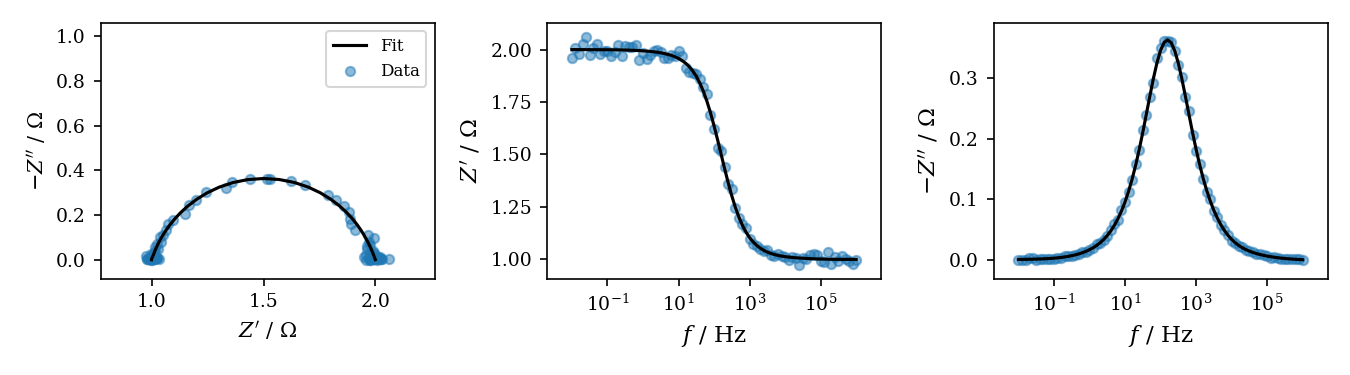

In [18]:
"Use predict_Z to obtain the impedance fit"
# Z_pred is a vector of complex numbers
Z_pred = inv_hmc.predict_Z(freq)
# This is just a convenience function which puts the impedance data into a Pandas dataframe
df_pred = gt.construct_eis_df(freq,Z_pred)

"Plot the fit using function from eis_utils"
# plot the data
axes = gt.plot_full_eis(Zdf,label='Data',s=20,alpha=0.5,bode_cols=['Zreal','Zimag'])
# plot the fit
axes = gt.plot_full_eis(df_pred,label='Fit',plot_func='plot',c='k',axes=axes,bode_cols=['Zreal','Zimag'])

The impedance fit is appropriate and avoids overfitting the noise in the data. Despite the significant amount of noise in the data, the CI for the impedance is very narrow, as shown in the plots below.

<IPython.core.display.Javascript object>


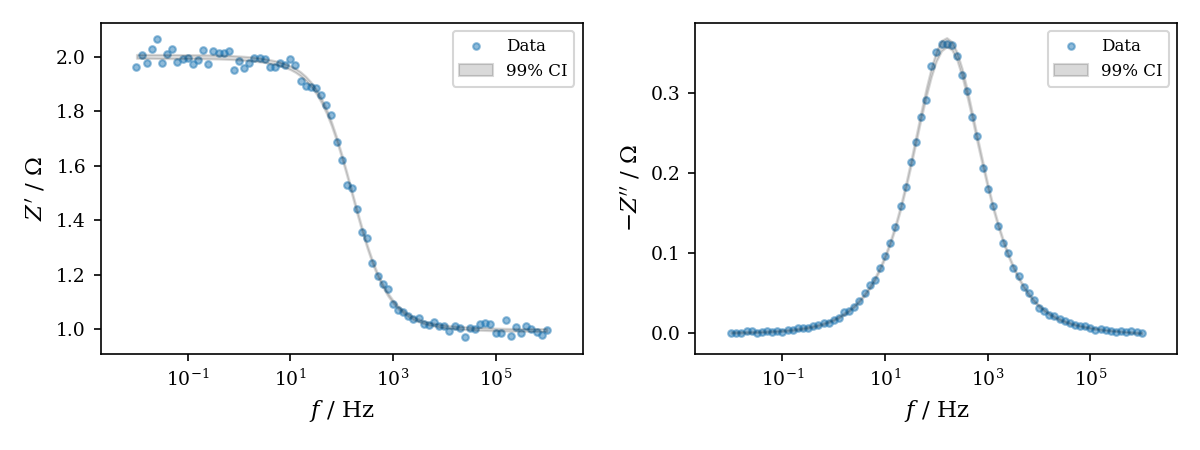

In [19]:
"Plot the impedance CIs"
# use predict_Z with percentile arg to get CI limits
Z_lo = inv_hmc.predict_Z(freq,percentile=0.5)
Z_hi = inv_hmc.predict_Z(freq,percentile=99.5)

# plot the data
axes = gt.plot_bode(Zdf,label='Data',s=10,alpha=0.5,cols=['Zreal','Zimag'])
# plot CIs on Bode plots
axes[0].fill_between(freq,Z_lo.real,Z_hi.real,color='k',alpha=0.15,label='99% CI')
axes[1].fill_between(freq,-Z_lo.imag,-Z_hi.imag,color='k',alpha=0.15,label='99% CI')

axes[0].legend()
axes[1].legend()

### Obtaining the ohmic resistance, inductance, and polarization resistance
The `Inverter` class provides estimates of the ohmic resistance, inductance, and polarization resistance. The ohmic resistance and inductance are stored in the `R_inf` and `inductance` attributes, while the polarization resistance can be evaluated with the `predict_Rp` method. `predict_Rp` also takes a `percentile` argument, which can be used to evaluate credible intervals for HMC sampling (i.e. `bayes_fit`) results.

In [59]:
print('Ohmic resistance = {:.5f} ohms'.format(inv_hmc.R_inf))
print('Inductance = {:.5e} H'.format(inv_hmc.inductance))
print('Polarization resistance = {:.5f} ohms'.format(inv_hmc.predict_Rp()))
print('Rp 2.5 percentile = {:.5f} ohms'.format(inv_hmc.predict_Rp(percentile=2.5)))
print('Rp 97.5 percentile = {:.5f} ohms'.format(inv_hmc.predict_Rp(percentile=97.5)))

Ohmic resistance = 0.99805 ohms
Inductance = 1.08767e-10 H
Polarization resistance = 1.00283 ohms
Rp 2.5 percentile = 0.99680 ohms
Rp 97.5 percentile = 1.00864 ohms


The estimates of the ohmic resistance, inductance, and polarization resistance are quite accurate. The true values are 1 $\Omega$, 0 H, and 1 $\Omega$, respectively. The uncertainty in the polarization resistance is quite small because the impedance response was fully captured by the measurement.

### Predicting the error structure
The CHB model also provides an estimate of the error structure of the impedance, accessible via the `predict_sigma` method. The error structure is quantified by the standard deviation (or scale) of the real and imaginary error at each measurement frequency.

<IPython.core.display.Javascript object>


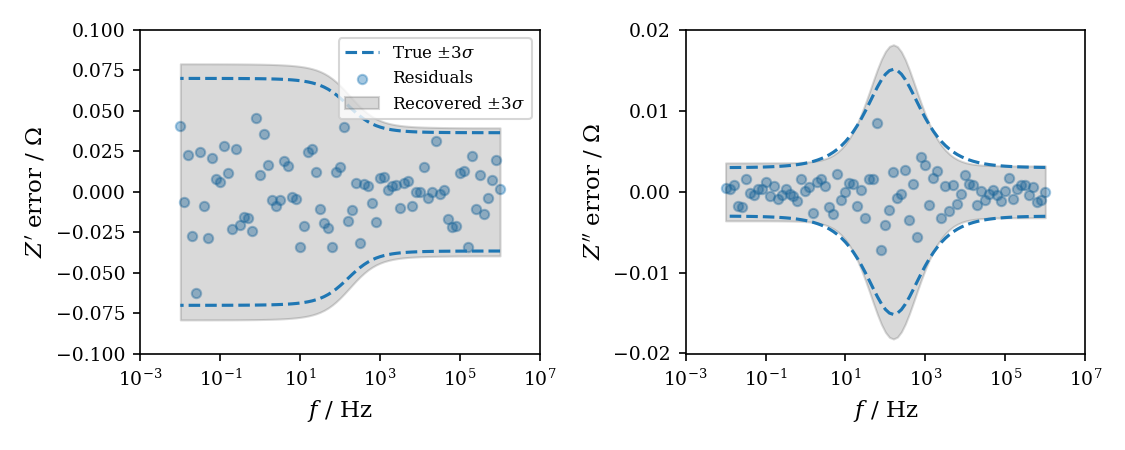

In [23]:
"Use predict_sigma to estimate the error scale"
sigma_re, sigma_im = inv_hmc.predict_sigma(freq)

fig,axes = plt.subplots(1,2,figsize=(7.5,3),sharex=True)

# plot residuals
Z_pred = inv_hmc.predict_Z(freq)
df_err = gt.construct_eis_df(freq,Z_pred-Zc)
gt.plot_bode(df_err,axes=axes,cols=['Zreal','Zimag'],alpha=0.4,s=20,label='Residuals',unit_scale='')

# plot true error scale
p = axes[0].plot(freq,3*Zdf['sigma_re'],ls='--',label='True $\pm 3\sigma$')
axes[0].plot(freq,-3*Zdf['sigma_re'],ls='--',c=p[0].get_color())
axes[1].plot(freq,3*Zdf['sigma_im'],ls='--')
axes[1].plot(freq,-3*Zdf['sigma_im'],ls='--',c=p[0].get_color())

# plot recovered error scale
axes[0].fill_between(freq,-3*sigma_re,3*sigma_re,color='k',alpha=0.15,label='Recovered $\pm3\sigma$')
axes[1].fill_between(freq,-3*sigma_im,3*sigma_im,color='k',alpha=0.15)


axes[0].legend()
axes[0].set_ylabel('$Z^\prime$ error $/ \ \Omega$')
axes[1].set_ylabel('$Z^{\prime\prime}$ error $/ \ \Omega$')
# make room for legend
axes[0].set_ylim(-0.1,0.1)
axes[0].set_xlim(1e-3,1e7)

fig.tight_layout()

The recovered error scale is fairly accurate for this spectrum, but slightly overestimates the error magnitude.

## 2b. CHB fit via L-BFGS optimization
We can also use the L-BFGS optimization algorithm in `Stan` to obtain a maximum *a posteriori* (MAP) estimate of the DRT by maximizing the posterior probability. This enables the CHB model to be fitted to the data much more quickly than is possible via HMC sampling, but does not provide a CI. This approach is accessible via the `map_fit` method.

In [52]:
# run L-BFGS MAP optimization
inv_map = Inverter()
start = time.time()
inv_map.map_fit(freq,Zc)
elapsed = time.time() - start
print('L-BFGS optimization time: {:.2f} s'.format(elapsed))

L-BFGS optimization time: 2.61 s


Note that it is not necessary to create a new `Inverter` instance for each fit or dataset; the same `Inverter` instance can be used to fit any number of datasets or run any number of different fits of the same dataset. **Since the `Inverter` object stores the calculated matrices for reuse, reusing the same instance for multiple fits usually saves calculation time. However, running a new fit will overwrite previous fit results.** Thus, for this example, we use a separate `Inverter` instance to maintain access to both the HMC and MAP fit results.

As for the HMC result, we examine the recovered DRT, impedance fit, and recovered error structure. This time, we define convenience functions for visualizing the results, which rely on the same methods and attributes of the `Inverter` class.

In [7]:
def plot_drt_result(inv,Zdf,g_true,plot_ci=False,c='k',label=None,axes=None,plot_data=True):
    "Plot recovered DRT and impedance fit"
    if axes is None:
        fig, axes = plt.subplots(2,2,figsize=(7.5,6))
    else:
        fig = axes.ravel()[0].get_figure()
    freq = Zdf['Freq'].values
    
    if label is None:
        Z_label = 'Fit'
        g_label = 'Recovered'
    else:
        Z_label = label
        g_label = label
    
    # plot noisy data
    if plot_data:
        gt.plot_full_eis(Zdf,axes=axes.ravel()[:3],alpha=0.4,label='Data',bode_cols=['Zreal','Zimag'],s=20)
    # get fitted impedance from DRT instance
    Z_pred = inv.predict_Z(freq)
    df_pred = gt.construct_eis_df(freq,Z_pred)
    # plot impedance fit
    gt.plot_full_eis(df_pred,axes=axes.ravel()[:3],alpha=0.8,label=Z_label,bode_cols=['Zreal','Zimag'],
                     c=c,plot_func='plot')

    # plot the true DRT
    if plot_data:
        axes[1,1].plot(g_true['tau'],g_true['gamma'],label='True',ls='--')
    # get the recovered DRT
    g_pred = inv.predict_distribution('DRT',g_true['tau'])
    # plot the recovered DRT
    if plot_ci:
        # plot mean and 95% credibility interval (CI) if HMC sampling used
        g_lo = inv.predict_distribution('DRT',g_true['tau'],percentile=2.5)
        g_hi = inv.predict_distribution('DRT',g_true['tau'],percentile=97.5)
        axes[1,1].plot(g_true['tau'],g_pred,c=c,label='Posterior mean',alpha=0.8)
        axes[1,1].fill_between(g_true['tau'],g_lo,g_hi,color=c,label='95% CI',alpha=0.15)
    else:
        # otherwise plot point estimate only
        axes[1,1].plot(g_true['tau'],g_pred,c=c,label=g_label,alpha=0.8)
        
    # plot zero line
    for ax in [axes[0,0],axes[1,0],axes[1,1]]:
        ax.axhline(0,c='k',lw=0.5,zorder=-10)
    
    axes[1,1].set_xscale('log')
    axes[1,1].set_xlabel(r'$\tau$ / s')
    axes[1,1].set_ylabel('$\gamma \ / \ \Omega$')

    for ax in axes.ravel():
        ax.legend()

    fig.tight_layout()
    return axes

def plot_resid(inv,Zdf):
    "Plot residuals and recovered error scale"
    fig,axes = plt.subplots(1,2,figsize=(7.5,3),sharex=True)
    freq = Zdf['Freq'].values
    Zc = Zdf['Zreal'].values + 1j*Zdf['Zimag'].values
    
    # plot residuals
    Z_pred = inv.predict_Z(freq)
    df_err = gt.construct_eis_df(freq,Z_pred-Zc)
    gt.plot_bode(df_err,axes=axes,cols=['Zreal','Zimag'],alpha=0.4,s=20,label='Residuals',unit_scale='')

    # plot true error scale
    p = axes[0].plot(freq,3*Zdf['sigma_re'],ls='--',label='True $\pm 3\sigma$')
    axes[0].plot(freq,-3*Zdf['sigma_re'],ls='--',c=p[0].get_color())
    axes[1].plot(freq,3*Zdf['sigma_im'],ls='--')
    axes[1].plot(freq,-3*Zdf['sigma_im'],ls='--',c=p[0].get_color())
    
    # plot zero line
    for ax in axes:
        ax.axhline(0,c='k',lw=0.5,zorder=-10)

    # get the recovered error scale
    sigma_re, sigma_im = inv.predict_sigma(freq)
    # plot recovered error scale
    axes[0].fill_between(freq,-3*sigma_re,3*sigma_re,color='k',alpha=0.15,label='Recovered $\pm3\sigma$')
    axes[1].fill_between(freq,-3*sigma_im,3*sigma_im,color='k',alpha=0.15)

    axes[0].legend()
    #make room for legend
    axes[0].set_ylim(-0.1,0.1)
    axes[0].set_xlim(1e-3,1e7)
    
    fig.tight_layout()

<IPython.core.display.Javascript object>


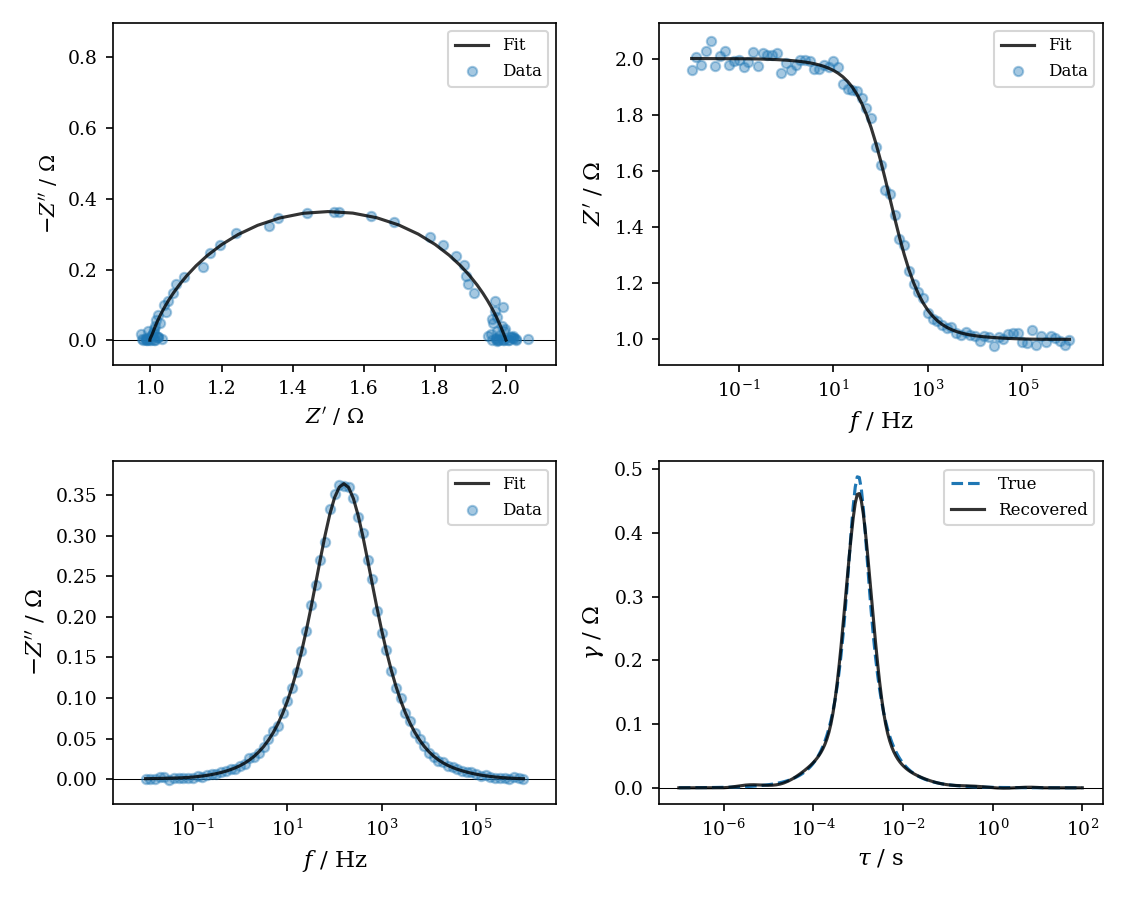

In [56]:
axes = plot_drt_result(inv_map,Zdf,g_true)

The MAP point estimate very closely matches the posterior mean from HMC sampling, but is obtained ~30 times faster (1.9 s vs. 53 s on my laptop).

Like the HMC solution, the MAP solution also provides an estimate of the error scale.

<IPython.core.display.Javascript object>


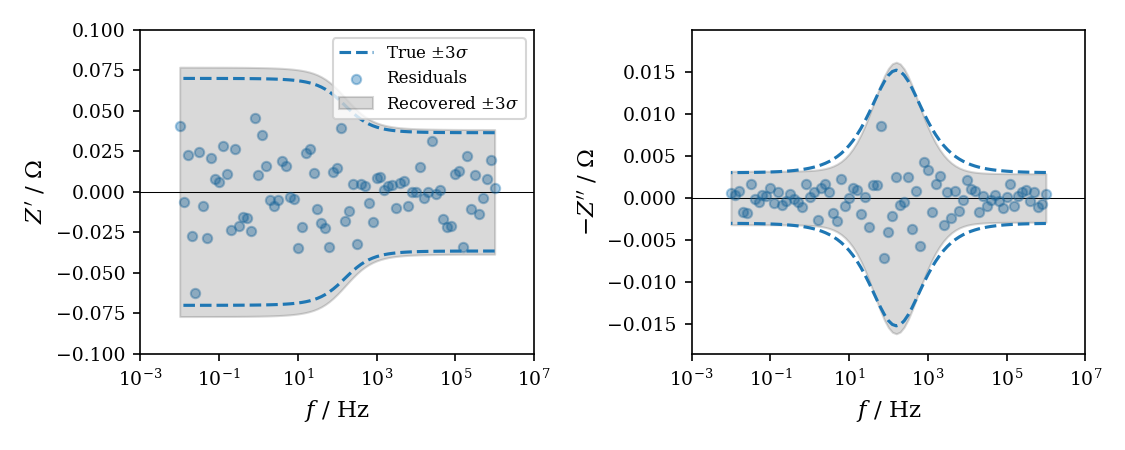

In [57]:
plot_resid(inv_map,Zdf)

The MAP error estimate is very similar to the HMC error estimate, but estimates slightly smaller imaginary errors.

## Enforcing non-negativity
Both the `bayes_fit` and `map_fit` methods can be applied with a non-negativity constraint (as has traditionally been used for the DRT) by passing the argument `nonneg_drt=True`, as shown below for the MAP optimization. The results with and without the non-negativity constraint are generally very similar, since the methods implemented are quite robust to pseudo-peaks and extraneous oscillations. However, in some cases, enforcing non-negativity seems to cause in some instability in the L-BFGS algorithm and can result in undesirably "spiky" solutions. In general, I would recommend running both `bayes_fit` and `map_fit` with `nonneg_drt=False` for best stability. If you find that there are undesired negative peaks in the resulting distribution, try running with `nonneg_drt=True`.

Below we illustrate the `map_fit` results with `nonneg_drt=True`.

In [30]:
# run MAP optimization with non-negativity constraint
start = time.time()
inv_map.map_fit(freq,Zc,nonneg_drt=True)
elapsed = time.time() - start
print('L-BFGS optimization time (non-negative): {:.2f} s'.format(elapsed))

L-BFGS optimization time (non-negative): 1.04 s


<IPython.core.display.Javascript object>


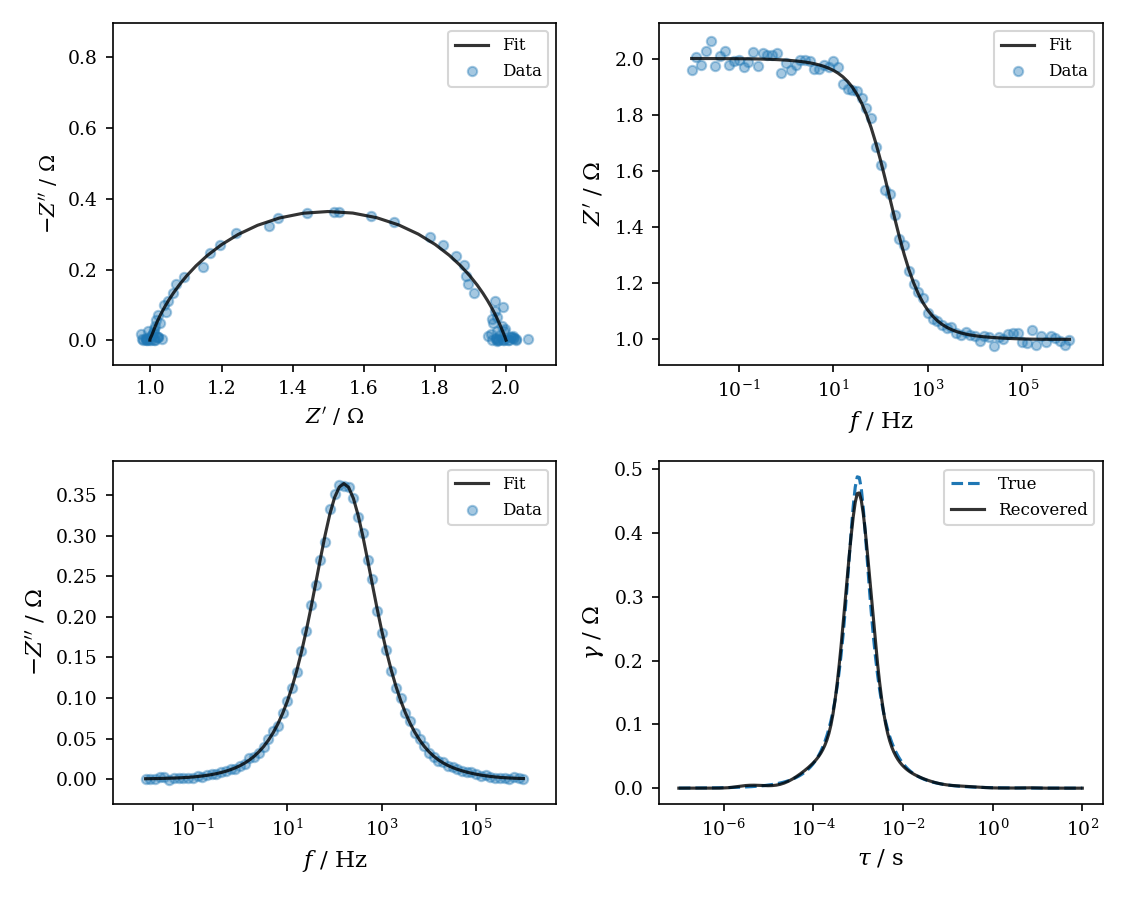

In [31]:
axes = plot_drt_result(inv_map,Zdf,g_true)

The recovered DRT is nearly identical to the solution obtained without a non-negativity constraint.

## 2c. Ciucci and Chen's hierarchical Bayesian algorithm

In addition to the CHB method developed in our work, the `Inverter` class provides access to an implementation of Ciucci and Chen's hierarchical Bayesian method for DRT recovery (https://doi.org/10.1016/j.electacta.2015.03.123), which is a hyperparametric ridge regression, as well as the hyper-w extension developed by Effat and Ciucci (https://doi.org/10.1016/j.electacta.2017.07.050). The hyperparametric ridge fit can be performed using the `ridge_fit` method of the `Inverter` class. For convenience, we provide a built-in real-imaginary cross-validation (Re-Im CV) function to tune the $\lambda_0$ hyperparameter, but the $f_\beta$ hyperparameter must be determined by the user. The recommendation is to test several values of $f_\beta$ and compare the results visually, as shown below (the higher $f_\beta$ is, the closer the result is to the ordinary ridge solution) . The $\epsilon$ parameter, which is the inverse length scale of the radial basis functions used to construct the DRT, must also be chosen carefully. For this example, a value of $\epsilon=2$ works well.

In [5]:
# create Inverter instance, specifying epsilon value
inv_ridge = Inverter(epsilon=2)

start = time.time()
# perform Re-Im CV to tune lambda_0
cv_lambda = inv_ridge.ridge_ReImCV(freq,Zc)
print('Optimized lambda_0: {}'.format(cv_lambda))
t1 = time.time()
print('Re-Im CV time: {} s'.format(round(t1-start,3)))
# perform hyperparametric ridge fit with optimized lambda_0 for several different values of f_beta
f_betas = [1e-2,1e-1,1]
fit_objs = []
for f_beta in f_betas:
    inv_ridge.ridge_fit(freq,Zc,lambda_0=cv_lambda,hl_fbeta=f_beta)
    fit_objs.append(deepcopy(inv_ridge))
print('Hyper-lambda fit time: {} s'.format(round(time.time()-t1,3)))

Optimized lambda_0: 0.0001
Re-Im CV time: 8.646 s
Hyper-lambda fit time: 0.422 s


<IPython.core.display.Javascript object>


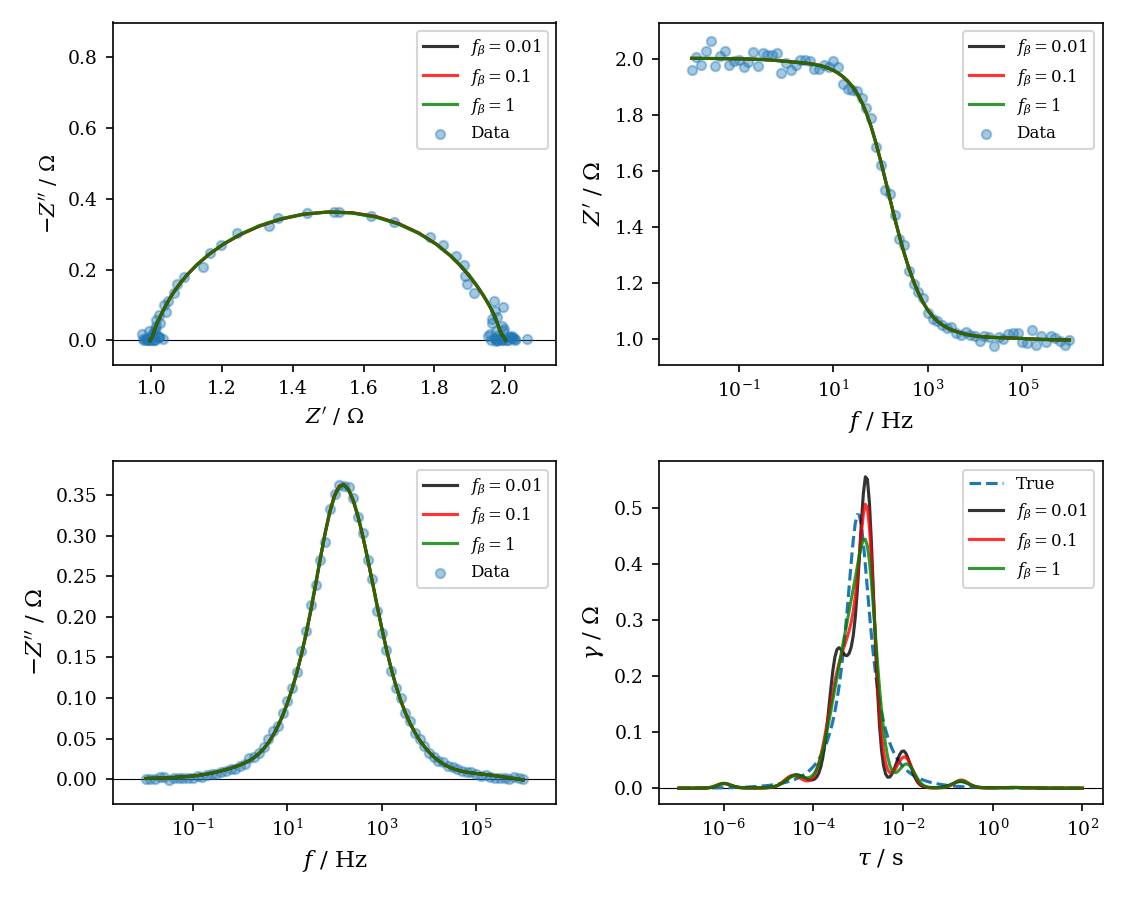

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


In [8]:
"Plot the results for each f_beta"
fig, axes = plt.subplots(2,2,figsize=(7.5,6))

for c,obj,f_beta in zip(['k','r','g'],fit_objs,f_betas):
    if f_beta==0.01:
        plot_data=True
    else:
        plot_data=False
    tax = plot_drt_result(obj,Zdf,g_true,axes=axes,label=r'$f_\beta={}$'.format(f_beta),
                          c=c,plot_data=plot_data)

For the three $f_\beta$ values tested, $f_\beta=0.1$ appears to yield the most accurate DRT, although all results are fairly distorted. The impedance fit is nearly identical for all $f_\beta$ values.

The `ridge_fit` method can also be run with `lambda_0='cv'` to automatically perform Re-Im CV to choose the `lambda_0` value, and then use that `lambda_0` value for the hyperparametric ridge fit. This achieves the same result as the above code (for a single value of $f_\beta$) with a single method call, as shown below.

In [9]:
start = time.time()
# perform hyperparametric ridge fit with Re-Im CV for f_beta=0.1
inv_ridge.ridge_fit(freq,Zc,lambda_0='cv',hl_fbeta=0.1)
print('Re-Im CV and hyper-lambda fit time: {:.2f} s'.format(time.time()-start))

Re-Im CV and hyper-lambda fit time: 7.82 s


<IPython.core.display.Javascript object>


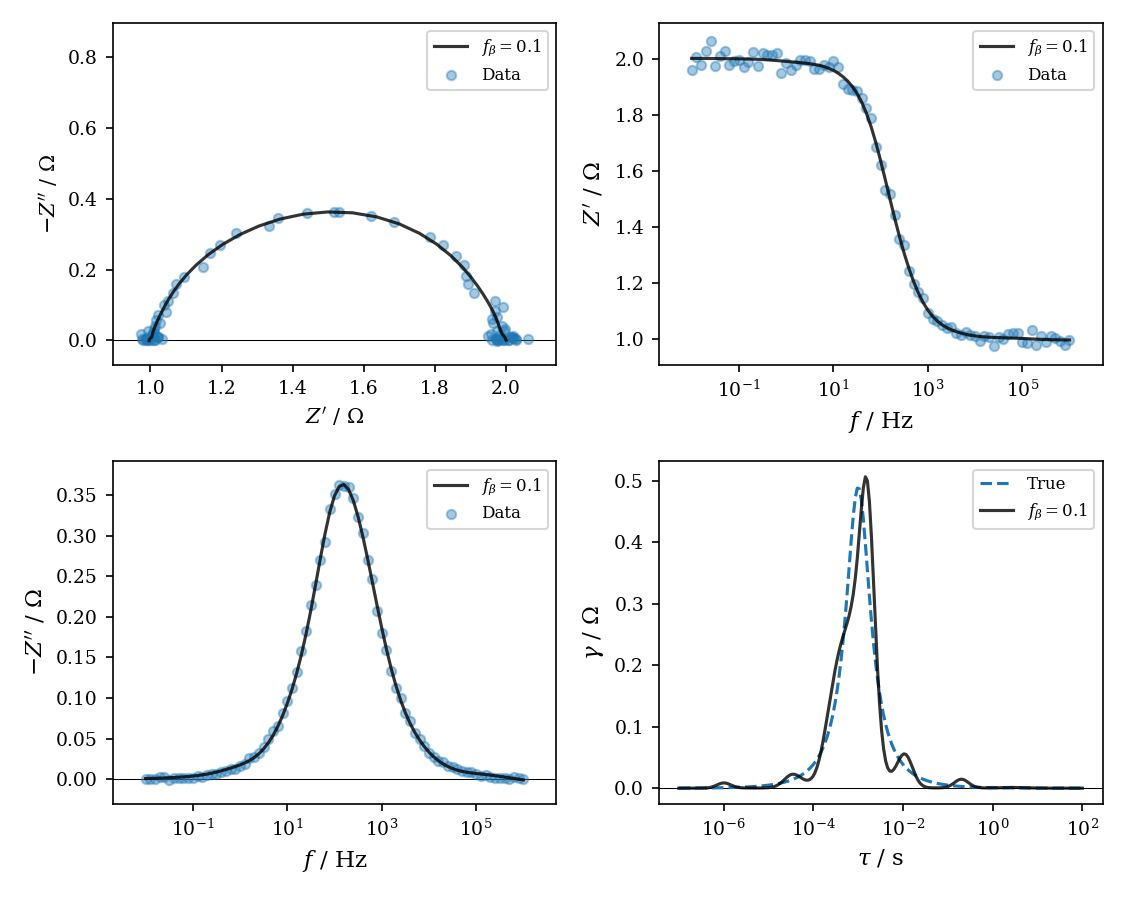

In [11]:
axes = plot_drt_result(inv_ridge,Zdf,g_true,label=r'$f_\beta=0.1$')